<h1>Basic Template For All NN</h1>

In [1]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

/home/team3/anaconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/team3/anaconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/team3/anaconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/team3/anaconda3/envs/gpu/lib/python3.7/site-packages

In [2]:
import keras
import pandas as pd
import tensorflow as tf

import numpy as np
# from keras.models import Sequential, Model
# from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import np_utils

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D, Input, AveragePooling2D

# from keras.applications import MobileNet
# from keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2, InceptionV3
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2
from matplotlib import pyplot as plt
import os
from sklearn.model_selection import train_test_split

import seaborn as sns
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import KFold

from collections import defaultdict
from PIL import Image

Using TensorFlow backend.


<h2>Data Loading and Preparation</h2>

In [3]:
def getEmotionCode(x):
    part = x.split('_')
    if part[2] == 'SAD':
        return 0
    elif part[2] == 'ANG':
        return 1
    elif part[2] == 'DIS':
        return 2
    elif part[2] == 'FEA':
        return 3
    elif part[2] == 'HAP':
        return 4
    elif part[2] == 'NEU':
        return 5
    else:
        return 'Unknown'
    
def getEmotion(x):
    if x == 0:
        return 'SAD'
    elif x == 1:
        return 'ANG'
    elif x == 2:
        return 'DIS'
    elif x == 3:
        return 'FEA'
    elif x == 4:
        return 'HAP'
    elif x == 5:
        return 'NEU'
    else:
        return 'Unknown'

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



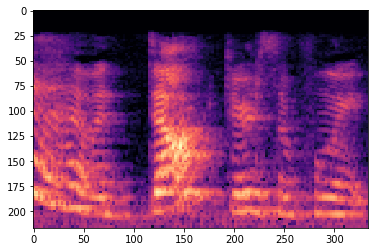

In [4]:
X_all = []
Y_all = []

image_folder_path = 'cremad/SpectogramInitial'
file_paths = [f for f in os.listdir(image_folder_path)]

for file_name in file_paths:
    spectrogram = Image.open(image_folder_path + '/' + file_name)
    spectrogram = spectrogram.convert('RGB')
    spectrogram = np.array(spectrogram)
    X_all.append(spectrogram)
    Y_all.append(getEmotionCode(file_name))
    
print(X_all)
print(Y_all)
plt.imshow(X_all[0])


In [5]:
X_all = np.array(X_all)
Y_all = np.array(Y_all)

print(X_all.shape)
print(Y_all.shape)

X_all = X_all.astype('float32')
X_all /= 255

Y_all = np_utils.to_categorical(Y_all, num_classes=6)

print(X_all)
print(Y_all)

(3512, 217, 334, 3)
(3512,)
[[[[0.         0.         0.01568628]
   [0.         0.         0.01568628]
   [0.         0.         0.01568628]
   ...
   [0.         0.         0.01568628]
   [0.         0.         0.01568628]
   [0.         0.         0.01568628]]

  [[0.         0.         0.01568628]
   [0.         0.         0.01568628]
   [0.         0.         0.01568628]
   ...
   [0.         0.         0.01568628]
   [0.         0.         0.01568628]
   [0.         0.         0.01568628]]

  [[0.         0.         0.01568628]
   [0.         0.         0.01568628]
   [0.         0.         0.01568628]
   ...
   [0.         0.         0.01568628]
   [0.         0.         0.01568628]
   [0.         0.         0.01568628]]

  ...

  [[0.54509807 0.16078432 0.5058824 ]
   [0.54509807 0.16078432 0.5058824 ]
   [0.6117647  0.18039216 0.49803922]
   ...
   [0.67058825 0.2        0.4862745 ]
   [0.5764706  0.16862746 0.5019608 ]
   [0.5764706  0.16862746 0.5019608 ]]

  [[0.54509807 0.

In [6]:
# train /test= 80/20% split
X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size=0.2, random_state = 123)



<h2>Model Building</h2>

In [8]:
def build_current_model():
    inp = Input(shape=(217, 334, 3))
    c1 = Convolution2D(filters=64,kernel_size=(7,7),strides=(2,2),padding='same',activation='relu')(inp)
    mpool1 = MaxPooling2D(pool_size=(3,3),strides=2,padding='same')(c1)
    
    c2 = Convolution2D(filters=128,kernel_size=(7,7),strides=(2,2),padding='same',activation='relu')(mpool1)
    mpool2 = AveragePooling2D(pool_size=(3,3),strides=(2,2),padding='same')(c2)
    
    c3 = Convolution2D(filters=256,kernel_size=(3,3),strides=(2,2),padding='same',activation='relu')(mpool2)
    mpool3 = AveragePooling2D(pool_size=(3,3),strides=(2,2),padding='same')(c3)
    
    c4 = Convolution2D(filters=512,kernel_size=(3,3),strides=(2,2),padding='same',activation='relu')(mpool3)
    
    f = Flatten()(c4)
    dp = Dropout(0.255)(f)
    x_dense = Dense(4096, activation='relu')(dp)
    
    dp2 = Dropout(0.255)(x_dense)
    x_dense2 = Dense(4096, activation='relu')(dp2)
    
    x_out = Dense(6, name='output', activation='softmax', kernel_regularizer = l2(0.01))(x_dense2)
    model = Model(inputs=inp, outputs=x_out)
    model.compile(optimizer='adadelta', 
                  loss='categorical_hinge', 
                  metrics = ['accuracy'])
    return model



In [8]:
model = build_current_model()
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 217, 334, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 109, 167, 64)      9472      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 55, 84, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 42, 128)       401536    
_________________________________________________________________
average_pooling2d (AveragePo (None, 14, 21, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 11, 256)        295168    
_________

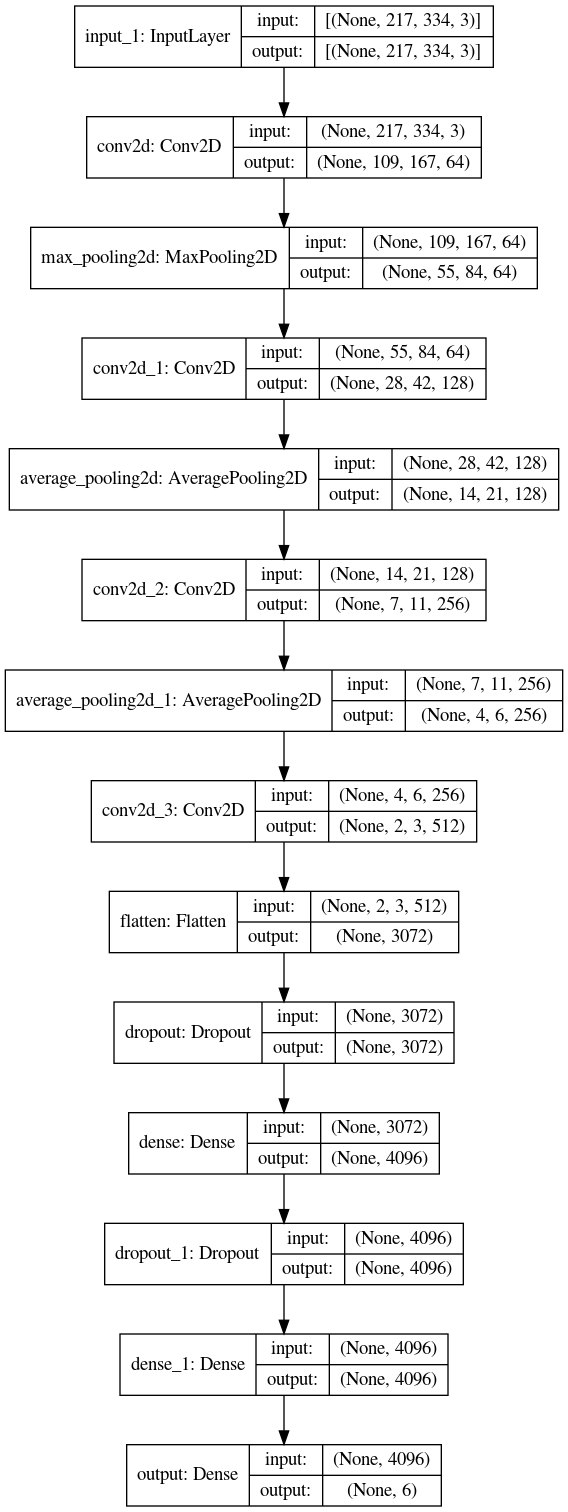

In [9]:
tf.keras.utils.plot_model(model, "Model-Ref2.png", show_shapes=True)

In [10]:
history = model.fit(X_train, Y_train, 
              epochs = 500, 
              validation_split=0.1, 
              verbose=1, 
              batch_size = 32)

history_info = history.history

Train on 2528 samples, validate on 281 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/500
2528/2528 [==============================] - 5s 2ms/sample - loss: 1.1216 - acc: 0.1768 - val_loss: 1.1201 - val_acc: 0.1779
Epoch 2/500
2528/2528 [==============================] - 4s 1ms/sample - loss: 1.1208 - acc: 0.1653 - val_loss: 1.1195 - val_acc: 0.1744
Epoch 3/500
2528/2528 [==============================] - 4s 1ms/sample - loss: 1.1201 - acc: 0.1705 - val_loss: 1.1190 - val_acc: 0.1601
Epoch 4/500
2528/2528 [==============================] - 4s 1ms/sample - loss: 1.1197 - acc: 0.1717 - val_loss: 1.1185 - val_acc: 0.1708
Epoch 5/500
2528/2528 [==============================] - 4s 1ms/sample - loss: 1.1191 - acc: 0.1673 - val_loss: 1.1180 - val_acc: 0.1957
Epoch 6/500
2528/2528 [==============================] - 4s 1ms/sample - loss: 1.1187 - acc: 0.1697 - val_loss: 1.1176 - val_acc: 0.1957
Epoch 7/500
2528/2528 [==============

2528/2528 [==============================] - 4s 2ms/sample - loss: 1.0830 - acc: 0.2729 - val_loss: 1.0828 - val_acc: 0.3665
Epoch 117/500
2528/2528 [==============================] - 4s 2ms/sample - loss: 1.0827 - acc: 0.2714 - val_loss: 1.0825 - val_acc: 0.3879
Epoch 118/500
2528/2528 [==============================] - 4s 2ms/sample - loss: 1.0825 - acc: 0.2749 - val_loss: 1.0823 - val_acc: 0.3843
Epoch 119/500
2528/2528 [==============================] - 4s 2ms/sample - loss: 1.0822 - acc: 0.2943 - val_loss: 1.0820 - val_acc: 0.3843
Epoch 120/500
2528/2528 [==============================] - 4s 2ms/sample - loss: 1.0820 - acc: 0.2690 - val_loss: 1.0818 - val_acc: 0.3772
Epoch 121/500
2528/2528 [==============================] - 4s 2ms/sample - loss: 1.0817 - acc: 0.2876 - val_loss: 1.0815 - val_acc: 0.3879
Epoch 122/500
2528/2528 [==============================] - 4s 2ms/sample - loss: 1.0814 - acc: 0.2911 - val_loss: 1.0812 - val_acc: 0.3843
Epoch 123/500
2528/2528 [================

2528/2528 [==============================] - 4s 2ms/sample - loss: 1.0688 - acc: 0.3299 - val_loss: 1.0687 - val_acc: 0.3915
Epoch 176/500
2528/2528 [==============================] - 4s 2ms/sample - loss: 1.0686 - acc: 0.3430 - val_loss: 1.0685 - val_acc: 0.3915
Epoch 177/500
2528/2528 [==============================] - 4s 2ms/sample - loss: 1.0684 - acc: 0.3505 - val_loss: 1.0683 - val_acc: 0.3915
Epoch 178/500
2528/2528 [==============================] - 4s 2ms/sample - loss: 1.0682 - acc: 0.3414 - val_loss: 1.0680 - val_acc: 0.3915
Epoch 179/500
2528/2528 [==============================] - 4s 2ms/sample - loss: 1.0680 - acc: 0.3497 - val_loss: 1.0678 - val_acc: 0.3879
Epoch 180/500
2528/2528 [==============================] - 4s 1ms/sample - loss: 1.0677 - acc: 0.3517 - val_loss: 1.0676 - val_acc: 0.3915
Epoch 181/500
2528/2528 [==============================] - 4s 2ms/sample - loss: 1.0675 - acc: 0.3477 - val_loss: 1.0674 - val_acc: 0.3879
Epoch 182/500
2528/2528 [================

2528/2528 [==============================] - 4s 1ms/sample - loss: 1.0571 - acc: 0.3671 - val_loss: 1.0570 - val_acc: 0.4342
Epoch 235/500
2528/2528 [==============================] - 4s 1ms/sample - loss: 1.0569 - acc: 0.3778 - val_loss: 1.0568 - val_acc: 0.4448
Epoch 236/500
2528/2528 [==============================] - 4s 2ms/sample - loss: 1.0567 - acc: 0.3801 - val_loss: 1.0566 - val_acc: 0.4342
Epoch 237/500
2528/2528 [==============================] - 4s 2ms/sample - loss: 1.0566 - acc: 0.3892 - val_loss: 1.0565 - val_acc: 0.4413
Epoch 238/500
2528/2528 [==============================] - 4s 2ms/sample - loss: 1.0564 - acc: 0.3900 - val_loss: 1.0563 - val_acc: 0.4270
Epoch 239/500
2528/2528 [==============================] - 4s 2ms/sample - loss: 1.0562 - acc: 0.3853 - val_loss: 1.0561 - val_acc: 0.4377
Epoch 240/500
2528/2528 [==============================] - 4s 2ms/sample - loss: 1.0560 - acc: 0.3928 - val_loss: 1.0559 - val_acc: 0.4306
Epoch 241/500
2528/2528 [================

2528/2528 [==============================] - 4s 2ms/sample - loss: 1.0474 - acc: 0.4055 - val_loss: 1.0473 - val_acc: 0.4698
Epoch 294/500
2528/2528 [==============================] - 4s 2ms/sample - loss: 1.0472 - acc: 0.4161 - val_loss: 1.0471 - val_acc: 0.4662
Epoch 295/500
2528/2528 [==============================] - 4s 2ms/sample - loss: 1.0471 - acc: 0.3956 - val_loss: 1.0470 - val_acc: 0.4662
Epoch 296/500
2528/2528 [==============================] - 4s 2ms/sample - loss: 1.0469 - acc: 0.4051 - val_loss: 1.0468 - val_acc: 0.4662
Epoch 297/500
2528/2528 [==============================] - 4s 1ms/sample - loss: 1.0468 - acc: 0.4142 - val_loss: 1.0467 - val_acc: 0.4484
Epoch 298/500
2528/2528 [==============================] - 4s 2ms/sample - loss: 1.0466 - acc: 0.4007 - val_loss: 1.0466 - val_acc: 0.4698
Epoch 299/500
2528/2528 [==============================] - 4s 2ms/sample - loss: 1.0465 - acc: 0.4059 - val_loss: 1.0464 - val_acc: 0.4626
Epoch 300/500
2528/2528 [================

2528/2528 [==============================] - 4s 2ms/sample - loss: 1.0393 - acc: 0.4276 - val_loss: 1.0392 - val_acc: 0.4804
Epoch 353/500
2528/2528 [==============================] - 4s 1ms/sample - loss: 1.0392 - acc: 0.4343 - val_loss: 1.0391 - val_acc: 0.4591
Epoch 354/500
2528/2528 [==============================] - 4s 1ms/sample - loss: 1.0391 - acc: 0.4379 - val_loss: 1.0390 - val_acc: 0.4662
Epoch 355/500
2528/2528 [==============================] - 4s 1ms/sample - loss: 1.0389 - acc: 0.4296 - val_loss: 1.0389 - val_acc: 0.4698
Epoch 356/500
2528/2528 [==============================] - 4s 2ms/sample - loss: 1.0388 - acc: 0.4391 - val_loss: 1.0388 - val_acc: 0.4804
Epoch 357/500
2528/2528 [==============================] - 4s 2ms/sample - loss: 1.0387 - acc: 0.4367 - val_loss: 1.0386 - val_acc: 0.4804
Epoch 358/500
2528/2528 [==============================] - 4s 1ms/sample - loss: 1.0386 - acc: 0.4308 - val_loss: 1.0385 - val_acc: 0.4840
Epoch 359/500
2528/2528 [================

2528/2528 [==============================] - 4s 2ms/sample - loss: 1.0326 - acc: 0.4375 - val_loss: 1.0326 - val_acc: 0.4733
Epoch 412/500
2528/2528 [==============================] - 4s 2ms/sample - loss: 1.0325 - acc: 0.4470 - val_loss: 1.0325 - val_acc: 0.4733
Epoch 413/500
2528/2528 [==============================] - 4s 1ms/sample - loss: 1.0324 - acc: 0.4454 - val_loss: 1.0324 - val_acc: 0.4769
Epoch 414/500
2528/2528 [==============================] - 4s 1ms/sample - loss: 1.0323 - acc: 0.4470 - val_loss: 1.0323 - val_acc: 0.4875
Epoch 415/500
2528/2528 [==============================] - 4s 1ms/sample - loss: 1.0322 - acc: 0.4359 - val_loss: 1.0322 - val_acc: 0.4982
Epoch 416/500
2528/2528 [==============================] - 4s 2ms/sample - loss: 1.0321 - acc: 0.4581 - val_loss: 1.0321 - val_acc: 0.4769
Epoch 417/500
2528/2528 [==============================] - 4s 2ms/sample - loss: 1.0320 - acc: 0.4529 - val_loss: 1.0320 - val_acc: 0.4662
Epoch 418/500
2528/2528 [================

2528/2528 [==============================] - 4s 2ms/sample - loss: 1.0271 - acc: 0.4486 - val_loss: 1.0270 - val_acc: 0.4769
Epoch 471/500
2528/2528 [==============================] - 4s 1ms/sample - loss: 1.0270 - acc: 0.4660 - val_loss: 1.0269 - val_acc: 0.4804
Epoch 472/500
2528/2528 [==============================] - 4s 2ms/sample - loss: 1.0269 - acc: 0.4462 - val_loss: 1.0269 - val_acc: 0.4840
Epoch 473/500
2528/2528 [==============================] - 4s 2ms/sample - loss: 1.0268 - acc: 0.4498 - val_loss: 1.0268 - val_acc: 0.4947
Epoch 474/500
2528/2528 [==============================] - 4s 2ms/sample - loss: 1.0267 - acc: 0.4632 - val_loss: 1.0267 - val_acc: 0.4733
Epoch 475/500
2528/2528 [==============================] - 4s 2ms/sample - loss: 1.0267 - acc: 0.4506 - val_loss: 1.0266 - val_acc: 0.4840
Epoch 476/500
2528/2528 [==============================] - 4s 1ms/sample - loss: 1.0266 - acc: 0.4470 - val_loss: 1.0265 - val_acc: 0.4733
Epoch 477/500
2528/2528 [================

<h2>Evaluation (Basic)</h2>

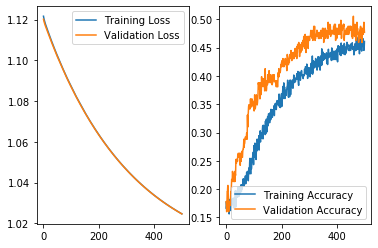

In [11]:
## Loss and accuracy history
_, axs = plt.subplots(ncols=2)
df_history_info = pd.DataFrame(history_info) 


sns.lineplot(data=df_history_info['loss'],ax=axs[0], label='Training Loss', legend='brief')
sns.lineplot(data=df_history_info['val_loss'],ax=axs[0], label='Validation Loss', legend='brief')

sns.lineplot(data=df_history_info['acc'],ax=axs[1], label='Training Accuracy', legend='brief')
sns.lineplot(data=df_history_info['val_acc'],ax=axs[1], label='Validation Accuracy', legend='brief')

In [13]:
def generate_actual_predicted(Y_pred, X_test, Y_test): 
    predicted = list()
    for i in range(len(Y_pred)):
        predicted.append(np.argmax(Y_pred[i]))
        
    actual = list()
    for i in range(len(Y_test)):
        actual.append(np.argmax(Y_test[i]))
        
    return actual, predicted

[[ 60   2   6   9   2  37]
 [  1 101   0   0   9   8]
 [ 23  19  18   9   7  50]
 [ 27  30   4  23  20  16]
 [  4  34   5   9  34  21]
 [ 13   9   4   1   6  82]]


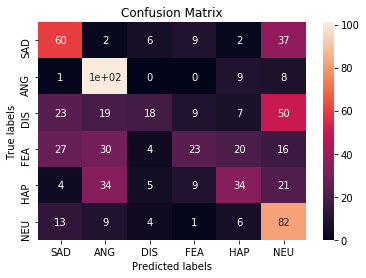

In [13]:
Y_pred = model.predict(X_test)
actual, predicted = generate_actual_predicted(Y_pred, X_test, Y_test)

##Confusion Matrix
from sklearn.metrics import confusion_matrix
actual_labeled = list()
predict_labeled = list()
for x,y in zip(actual,predicted):
    actual_labeled.append(getEmotion(x))
    predict_labeled.append(getEmotion(y))

labels = ['SAD','ANG','DIS','FEA','HAP','NEU']
cm=confusion_matrix(actual_labeled,predict_labeled,labels=labels)
print(cm)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);

In [14]:
## Test accuracy
from sklearn.metrics import accuracy_score
print('accuracy', accuracy_score(actual, predicted))


accuracy 0.4523470839260313


In [15]:
## Precision, Recall, F1, Support
from sklearn.metrics import classification_report
print(classification_report(actual_labeled, predict_labeled,labels=labels))

              precision    recall  f1-score   support

         SAD       0.47      0.52      0.49       116
         ANG       0.52      0.85      0.64       119
         DIS       0.49      0.14      0.22       126
         FEA       0.45      0.19      0.27       120
         HAP       0.44      0.32      0.37       107
         NEU       0.38      0.71      0.50       115

    accuracy                           0.45       703
   macro avg       0.46      0.46      0.42       703
weighted avg       0.46      0.45      0.41       703



In [16]:
##ROC AUC Scores
from sklearn.metrics import roc_auc_score
print('One-vs-One ROC AUC scores:')
print(roc_auc_score(actual, Y_pred, average='macro', multi_class='ovo'), '(macro)')
print(roc_auc_score(actual, Y_pred, average='weighted', multi_class='ovo'), '(weighted by prevalence)')


print()
print('One-vs-Rest ROC AUC scores:')
print(roc_auc_score(actual, Y_pred, average='macro', multi_class='ovr'), '(macro)')
print(roc_auc_score(actual, Y_pred, average='weighted', multi_class='ovr'), '(weighted by prevalence)')

One-vs-One ROC AUC scores:
0.8013151901500847 (macro)
0.8011578451815066 (weighted by prevalence)

One-vs-Rest ROC AUC scores:
0.8012505508776712 (macro)
0.8009905958597832 (weighted by prevalence)


/home/team3/anaconda3/envs/gpu/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


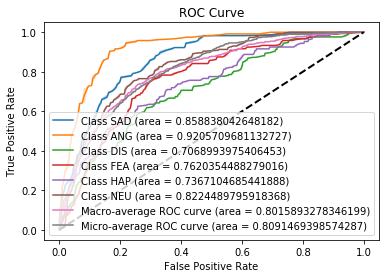

In [17]:
## ROC Curves
from sklearn.metrics import roc_curve, auc
import seaborn as sns
from scipy import interp

### The following curves are generated s.t each point is a model from differing thresholds

### ROC Curves + AUC per class

_, axs = plt.subplots(ncols=1)
axs.set(xlabel='False Positive Rate',ylabel='True Positive Rate', title='ROC Curve')

fpr = [0] * 6
tpr = [0] * 6
for i in range(6):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:,i], Y_pred[:,i])
    auc_val = auc(fpr[i], tpr[i])
    sns.lineplot(x=fpr[i],y=tpr[i],ax=axs, label='Class '+ getEmotion(i) +' (area = ' + str(auc_val) + ')', legend='brief')

#### Micro/Macro ROC Curves + AUC over all classes

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(6)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(6):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= 6

fpr_macro = all_fpr
tpr_macro = mean_tpr
roc_auc_macro = auc(fpr_macro, tpr_macro)
fpr_micro, tpr_micro,_ = roc_curve(Y_test.ravel(), Y_pred.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

sns.lineplot(x=fpr_macro,y=tpr_macro,ax=axs, label='Macro-average ROC curve (area = ' + str(roc_auc_macro) + ')', legend='brief')
sns.lineplot(x=fpr_micro,y=tpr_micro,ax=axs, label='Micro-average ROC curve (area = ' + str(roc_auc_micro) + ')', legend='brief')

## Diagonal line for comparison
plt.plot([0, 1], [0, 1], 'k--', lw=2)

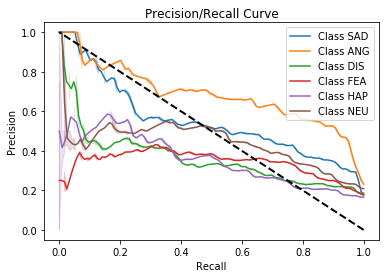

In [18]:
## Precision/Recall Curves per class
### The following curves are generated s.t each point is a model from differing thresholds
from sklearn.metrics import precision_recall_curve

_, axs = plt.subplots(ncols=1)
axs.set(xlabel='Recall',ylabel='Precision', title='Precision/Recall Curve')

prec = [0] * 6
rec = [0] * 6
for i in range(6):
    prec[i], rec[i], _ = precision_recall_curve(Y_test[:,i], Y_pred[:,i])
    sns.lineplot(x=rec[i],y=prec[i],ax=axs, label='Class '+ getEmotion(i), legend='brief')

# Diagonal line for comparison
plt.plot([1, 0], [0, 1], 'k--', lw=2)

<h2>K-Fold Training and Evaluation</h2>

In [19]:
#Precision Mean and Standard Deviation
#Recall Mean and Standard Deviation
#F1 Measure Mean and Standard Deviation
#True Positive Rate. Mean and Standard Deviation
#False Negative Rate Mean and Standard Deviation
#Best/Worst ROC
#Best/Worst Precision/Recall
#Accuracy Mean and Standard Deviation

In [15]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve


all_base_precision = list()
all_base_recall = list()
all_macro_precision = list()
all_macro_recall = list()
all_f1 = list()
all_macro_f1 = list()


all_tpr = list()
all_fpr = list()
all_precision = list()
all_recall = list()

all_accuracy = list()


n_split=3
for train_index,test_index in KFold(n_split).split(X_all):  
    # use the index to generate training an testing sets
    x_train,x_test=X_all[train_index],X_all[test_index]
    y_train,y_test=Y_all[train_index],Y_all[test_index]

    # create and fit the model
    cv_model=build_current_model()
    history = cv_model.fit(x_train, y_train,
              batch_size=32,
              epochs=100,
              validation_split=0,
              verbose=1)
    
    #generate predictions
    y_pred = cv_model.predict(x_test)
    actual, predicted = generate_actual_predicted(y_pred, x_test, y_test)
    
    #calc metrics
    curr_base_prec, curr_base_rec, curr_f1, _ = precision_recall_fscore_support(actual, predicted)
    curr_macro_prec = precision_score(actual, predicted,average='macro')
    curr_macro_rec = recall_score(actual, predicted,average='macro')
    curr_macro_f1 = f1_score(actual, predicted,average='macro')

    
    curr_fpr = [0] * 6
    curr_tpr = [0] * 6
    for i in range(6):
        curr_fpr[i], curr_tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])
        
    curr_prec = [0] * 6
    curr_rec = [0] * 6
    for i in range(6):
        curr_prec[i], curr_rec[i], _ = precision_recall_curve(y_test[:,i], y_pred[:,i])

        
    curr_accuracy = accuracy_score(actual, predicted)
    
    #add to lists
    all_base_precision.append(curr_base_prec)
    all_base_recall.append(curr_base_rec)
    all_macro_precision.append(curr_macro_prec)
    all_macro_recall.append(curr_macro_rec)
    
    all_f1.append(curr_f1)
    all_macro_f1.append(curr_macro_f1)
    
    all_accuracy.append(curr_accuracy)

    
    all_fpr.append(curr_fpr)
    all_tpr.append(curr_tpr)
    all_precision.append(curr_prec)
    all_recall.append(curr_rec)
    
    


Epoch 1/100
2341/2341 [==============================] - 3s 1ms/sample - loss: 1.1210 - acc: 0.1781
Epoch 2/100
2341/2341 [==============================] - 3s 1ms/sample - loss: 1.1201 - acc: 0.1760
Epoch 3/100
2341/2341 [==============================] - 3s 1ms/sample - loss: 1.1196 - acc: 0.1670
Epoch 4/100
2341/2341 [==============================] - 3s 1ms/sample - loss: 1.1191 - acc: 0.1743
Epoch 5/100
2341/2341 [==============================] - 3s 1ms/sample - loss: 1.1187 - acc: 0.1828
Epoch 6/100
2341/2341 [==============================] - 3s 1ms/sample - loss: 1.1184 - acc: 0.1559
Epoch 7/100
2341/2341 [==============================] - 3s 1ms/sample - loss: 1.1179 - acc: 0.1670
Epoch 8/100
2341/2341 [==============================] - 3s 1ms/sample - loss: 1.1176 - acc: 0.1623
Epoch 9/100
2341/2341 [==============================] - 3s 1ms/sample - loss: 1.1172 - acc: 0.1674
Epoch 10/100
2341/2341 [==============================] - 3s 1ms/sample - loss: 1.1168 - acc: 0.1786

2341/2341 [==============================] - 3s 1ms/sample - loss: 1.0936 - acc: 0.2170
Epoch 83/100
2341/2341 [==============================] - 3s 1ms/sample - loss: 1.0933 - acc: 0.2127
Epoch 84/100
2341/2341 [==============================] - 3s 1ms/sample - loss: 1.0930 - acc: 0.2388
Epoch 85/100
2341/2341 [==============================] - 3s 1ms/sample - loss: 1.0927 - acc: 0.2221
Epoch 86/100
2341/2341 [==============================] - 3s 1ms/sample - loss: 1.0924 - acc: 0.2226
Epoch 87/100
2341/2341 [==============================] - 3s 1ms/sample - loss: 1.0922 - acc: 0.2132
Epoch 88/100
2341/2341 [==============================] - 3s 1ms/sample - loss: 1.0919 - acc: 0.2238
Epoch 89/100
2341/2341 [==============================] - 3s 1ms/sample - loss: 1.0916 - acc: 0.2354
Epoch 90/100
2341/2341 [==============================] - 3s 1ms/sample - loss: 1.0913 - acc: 0.2149
Epoch 91/100
2341/2341 [==============================] - 3s 1ms/sample - loss: 1.0911 - acc: 0.2247
Epo

2341/2341 [==============================] - 3s 1ms/sample - loss: 1.1002 - acc: 0.1974
Epoch 64/100
2341/2341 [==============================] - 3s 1ms/sample - loss: 1.0999 - acc: 0.2025
Epoch 65/100
2341/2341 [==============================] - 3s 1ms/sample - loss: 1.0996 - acc: 0.1841
Epoch 66/100
2341/2341 [==============================] - 3s 1ms/sample - loss: 1.0993 - acc: 0.1918
Epoch 67/100
2341/2341 [==============================] - 3s 1ms/sample - loss: 1.0990 - acc: 0.2029
Epoch 68/100
2341/2341 [==============================] - 3s 1ms/sample - loss: 1.0987 - acc: 0.1833
Epoch 69/100
2341/2341 [==============================] - 3s 1ms/sample - loss: 1.0984 - acc: 0.2003
Epoch 70/100
2341/2341 [==============================] - 3s 1ms/sample - loss: 1.0981 - acc: 0.1952
Epoch 71/100
2341/2341 [==============================] - 3s 1ms/sample - loss: 1.0978 - acc: 0.1961
Epoch 72/100
2341/2341 [==============================] - 3s 1ms/sample - loss: 1.0976 - acc: 0.1948
Epo

/home/team3/anaconda3/envs/gpu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/team3/anaconda3/envs/gpu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
2342/2342 [==============================] - 4s 2ms/sample - loss: 1.1220 - acc: 0.1682
Epoch 2/100
2342/2342 [==============================] - 3s 1ms/sample - loss: 1.1212 - acc: 0.1755
Epoch 3/100
2342/2342 [==============================] - 3s 1ms/sample - loss: 1.1207 - acc: 0.1652
Epoch 4/100
2342/2342 [==============================] - 3s 1ms/sample - loss: 1.1202 - acc: 0.1734
Epoch 5/100
2342/2342 [==============================] - 3s 1ms/sample - loss: 1.1198 - acc: 0.1682
Epoch 6/100
2342/2342 [==============================] - 3s 1ms/sample - loss: 1.1194 - acc: 0.1678
Epoch 7/100
2342/2342 [==============================] - 3s 1ms/sample - loss: 1.1191 - acc: 0.1576
Epoch 8/100
2342/2342 [==============================] - 3s 1ms/sample - loss: 1.1187 - acc: 0.1627
Epoch 9/100
2342/2342 [==============================] - 3s 1ms/sample - loss: 1.1183 - acc: 0.1759
Epoch 10/100
2342/2342 [==============================] - 3s 1ms/sample - loss: 1.1180 - acc: 0.1529

2342/2342 [==============================] - 3s 1ms/sample - loss: 1.0947 - acc: 0.2148
Epoch 83/100
2342/2342 [==============================] - 3s 1ms/sample - loss: 1.0944 - acc: 0.2126
Epoch 84/100
2342/2342 [==============================] - 3s 1ms/sample - loss: 1.0941 - acc: 0.2109
Epoch 85/100
2342/2342 [==============================] - 3s 1ms/sample - loss: 1.0938 - acc: 0.2084
Epoch 86/100
2342/2342 [==============================] - 3s 1ms/sample - loss: 1.0936 - acc: 0.2246
Epoch 87/100
2342/2342 [==============================] - 3s 1ms/sample - loss: 1.0933 - acc: 0.2242
Epoch 88/100
2342/2342 [==============================] - 3s 1ms/sample - loss: 1.0930 - acc: 0.2242
Epoch 89/100
2342/2342 [==============================] - 3s 1ms/sample - loss: 1.0927 - acc: 0.2122
Epoch 90/100
2342/2342 [==============================] - 3s 1ms/sample - loss: 1.0924 - acc: 0.2225
Epoch 91/100
2342/2342 [==============================] - 3s 1ms/sample - loss: 1.0922 - acc: 0.2374
Epo

/home/team3/anaconda3/envs/gpu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/team3/anaconda3/envs/gpu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
print('precision mean by class', np.array(all_base_precision).mean(axis=0))
print('precision sdev by class', np.array(all_base_precision).std(axis=0))

print('macro precision mean', np.array(all_macro_precision).mean())
print('macro precision sdev', np.array(all_macro_precision).std())


print('recall mean', np.array(all_base_recall).mean(axis=0))
print('recall sdev', np.array(all_base_recall).std(axis=0))

print('macro recall mean', np.array(all_macro_recall).mean())
print('macro recall sdev', np.array(all_macro_recall).std())

print('f1 mean', np.array(all_f1).mean(axis=0))
print('f1 sdev', np.array(all_f1).std(axis=0))

print('macro f1 mean', np.array(all_macro_f1).mean())
print('macro f1 sdev', np.array(all_macro_f1).std())

print('accuracy mean', np.array(all_accuracy).mean())
print('accuracy sdev', np.array(all_accuracy).std())



precision mean by class [0.31159844 0.50710715 0.22535186 0.23870344 0.16145324 0.15388855]
precision sdev by class [0.01158301 0.07087885 0.01792656 0.02692096 0.11416486 0.11224417]
macro precision mean 0.26635044570430594
macro precision sdev 0.02477258595436984
recall mean [0.59971892 0.53114788 0.17282593 0.17214613 0.07578151 0.26486291]
recall sdev [0.12872363 0.19537768 0.19586727 0.12541978 0.06185581 0.20420487]
macro recall mean 0.3027472144614229
macro recall sdev 0.0029789934486912028
f1 mean [0.40672774 0.48900692 0.14289714 0.16147535 0.10061962 0.18746133]
f1 sdev [0.04275689 0.05555046 0.12066913 0.09607791 0.07679763 0.13255811]
macro f1 mean 0.2480313505148661
macro f1 sdev 0.01217817243001411
accuracy mean 0.30182107483559234
accuracy sdev 0.006999662599127164


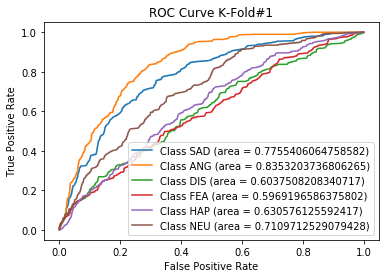

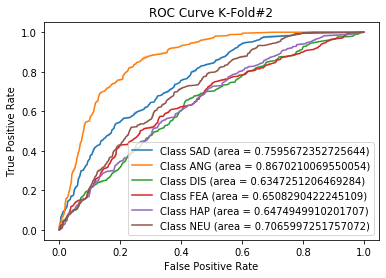

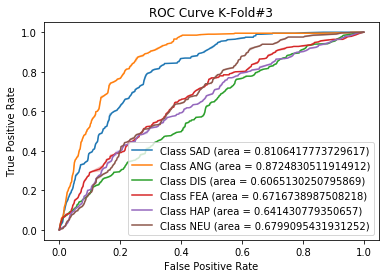

In [17]:
# Plot all K-Fold ROC curves
for i in range(3):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='False Positive Rate',ylabel='True Positive Rate', title='ROC Curve K-Fold#'+str(i+1))
    for j in range(6):
        auc_val = auc(all_fpr[i][j], all_tpr[i][j])
        sns.lineplot(x=all_fpr[i][j],y=all_tpr[i][j],ax=axs, label='Class '+ getEmotion(j) +' (area = ' + str(auc_val) + ')', legend='brief')
        

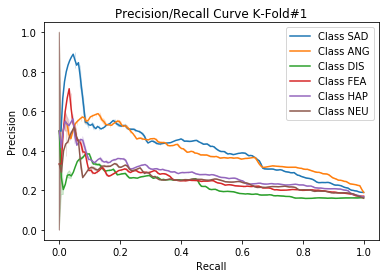

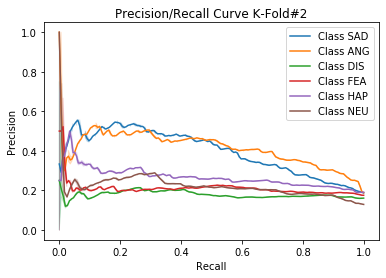

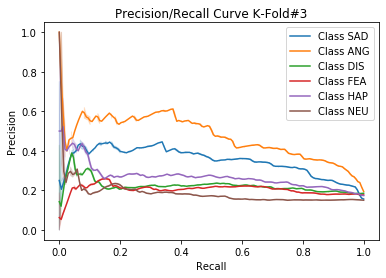

In [23]:
#Plot all K-Fold Precision/Recall curves
for i in range(3):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='Recall',ylabel='Precision', title='Precision/Recall Curve K-Fold#'+str(i+1))
    for j in range(6):
        sns.lineplot(x=all_recall[i][j],y=all_precision[i][j],ax=axs, label='Class '+ getEmotion(j), legend='brief')

<h2>Storing/Loading history and model to file</h2>

In [50]:
#Store History
hist_df = pd.DataFrame(history.history) 
hist_json_file = 'history.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

In [51]:
#Load History 
history_info = pd.read_json('history.json')

In [52]:
##Save Model
model.save('mobile_net_trained.model') #Save the model

In [53]:
## Load Model
model = tf.keras.models.load_model('mobile_net_trained.model') #Re load model